In [141]:
import os
from tifffile import imread
from skimage.measure import regionprops
from scipy.ndimage import find_objects
import numpy as np
import nd2
import pandas as pd

from tqdm.notebook import trange, tqdm

import seaborn as sns

In [62]:
root = "/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure"
model = "2025_12_22_Dasha_ibm-01"

In [164]:
def calc_ratios(values):
    means = np.concat((
        np.mean(values, axis=0)[np.newaxis, :],
        np.percentile(values, q=[50, 75, 90, 95], axis=0),
    ), axis=0)
    return np.concat((means[:, 1] / means[:, 0], means[:, 0], means[:, 1]))

value_vars = ["mean", "median", "75 %", "90 %", "95 %"]
def calc_df(t, m, file):
    filename = f"{file}_t{t}_m{m}_mScarlet.tiff"
    
    lbl = imread(os.path.join(root, "nfmp_prob0.6", model, filename))
    
    nd2_file = nd2.ND2File(os.path.join(root, file+".nd2"))
    img = nd2_file.to_dask()[t, m, :, 1:].compute().transpose(0, 2, 3, 1)
    lbl = lbl[:img.shape[0]]
    nd2_file.close()

    bg = np.median(img[lbl==0], axis=0)
    print(bg)
    img = img - bg
    
    objects = find_objects(lbl)

    values = []
    lbl_id = []
    for i, sl in enumerate(objects, 1):
        if sl is None: continue
        mask = lbl[sl] == i
        values.append(calc_ratios(img[sl][mask]))
        lbl_id.append(i)
    values_np = np.stack(values, axis=0)

    dfs = []
    for j, ty in enumerate(["ratio", "mScarlet", "gfp"]):
        values = {t: values_np[:, i+j*len(value_vars)] for i, t in enumerate(value_vars)}
        values["t"] = t
        values["m"] = m
        values["file"] = file
        values["insert"] = file.split("_")[-1]
        values["lbl_id"] = lbl_id
        values["type"] = ty
        dfs.append(pd.DataFrame(values))
    return pd.concat(dfs, ignore_index=True)

In [165]:
lbl.shape

(56, 2304, 2304)

In [166]:
dfs = []
for t in range(2):
    for m in trange(1):
        for i in tqdm([1]):#, 3, 4], leave=False):
            dfs.append(
                calc_df(t, m, f"Fig.4_h_TrimFABS_ANOX_mScarlet_insert{i}")
            )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[175. 238.]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[177. 235.]


In [200]:
df = pd.concat(dfs, ignore_index=True)
df = df.melt(id_vars=["t", "m", "file", "lbl_id", "type"], value_vars=value_vars, var_name="quantification")
df = df.pivot_table(columns="type", values="value", index=["t", "m", "file", "lbl_id", "quantification"]).reset_index()
df = df[df["ratio"]>0]
df = df[df["ratio"]<10]

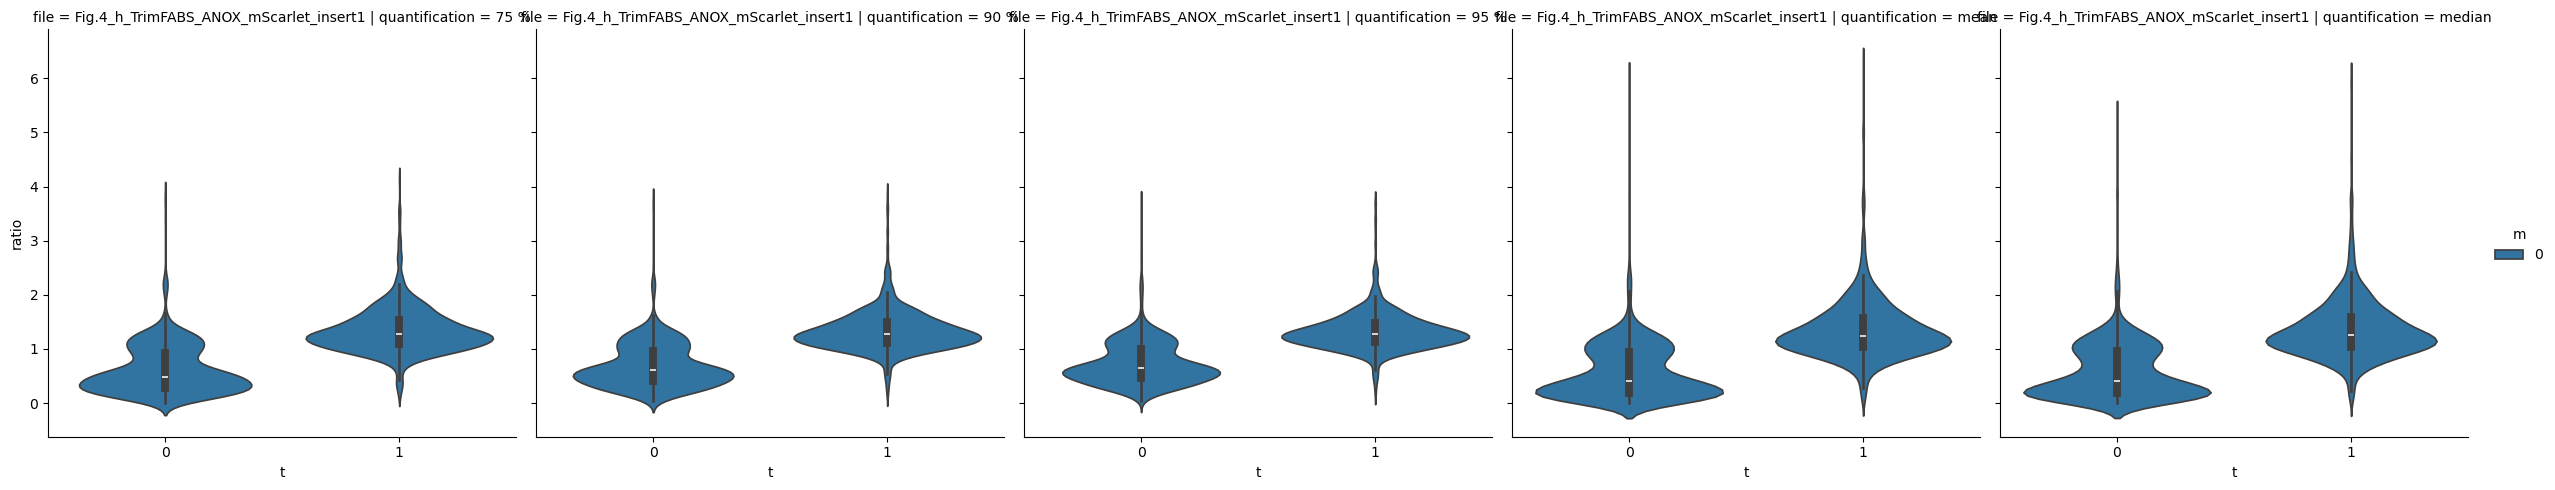

In [201]:
sns.catplot(
    data=df,
    x="t",
    y="ratio",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

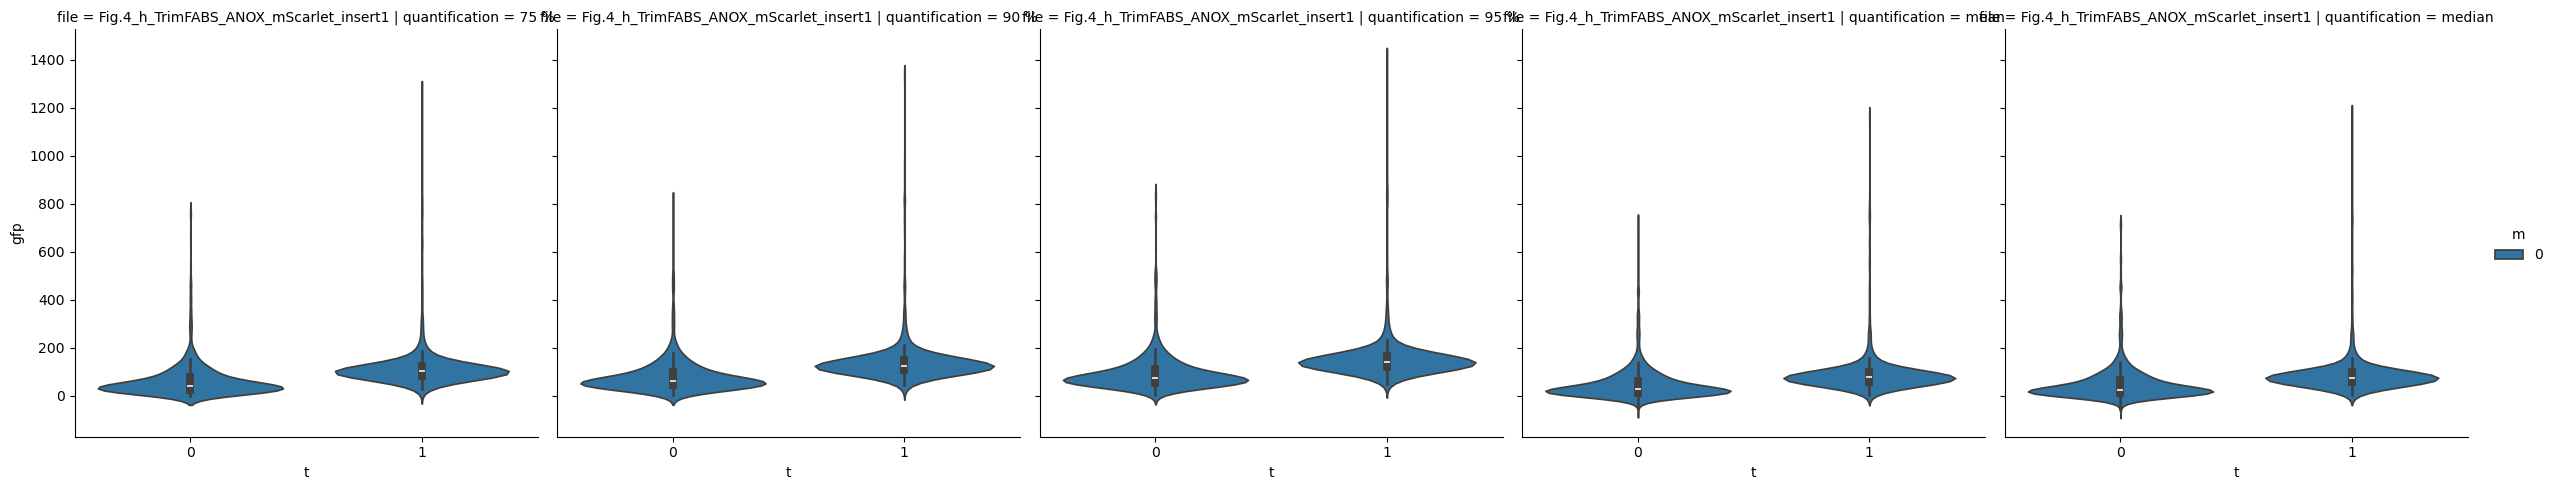

In [202]:
sns.catplot(
    data=df,
    x="t",
    y="gfp",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

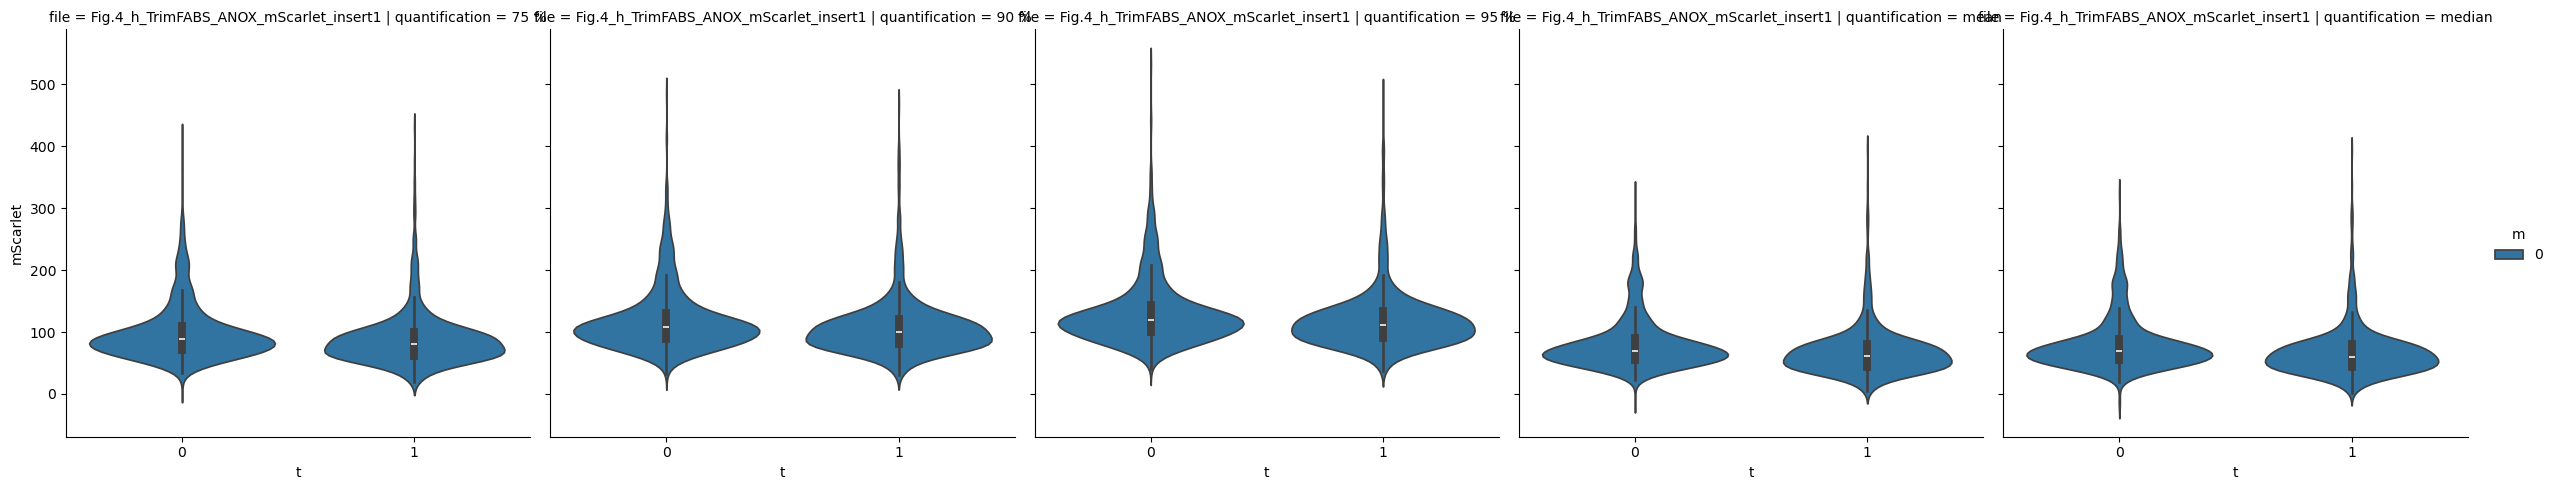

In [203]:
sns.catplot(
    data=df,
    x="t",
    y="mScarlet",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

/home/niklas/miniconda3/envs/vis/lib/python3.13/site-packages/matplotlib/transforms.py:194: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  ref = weakref.ref(


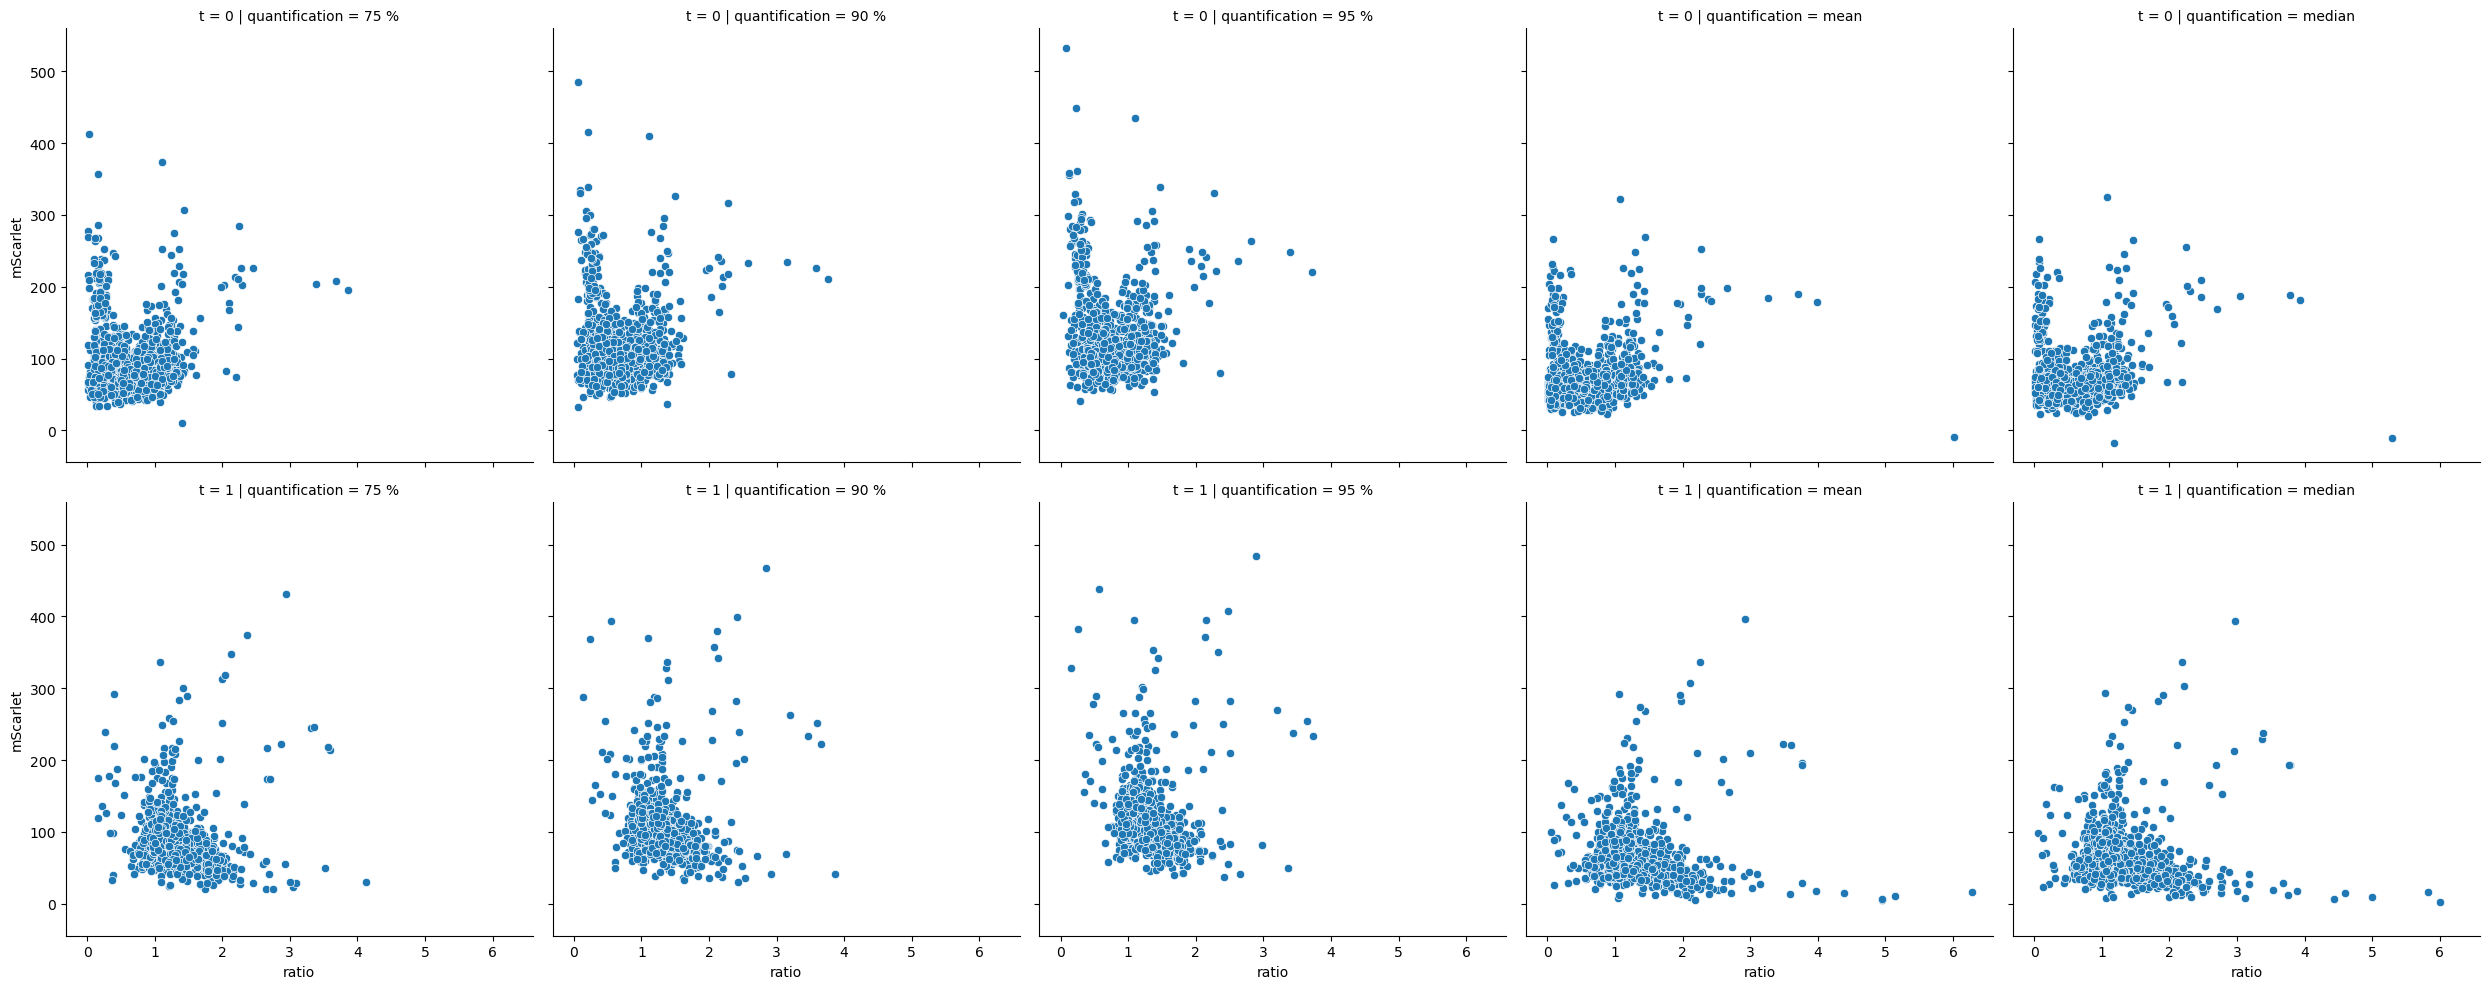

In [204]:
sns.relplot(
    data=df,
    x="ratio",
    y="mScarlet",
    col="quantification",
    row="t",
)

In [185]:
df.pivot_table(columns="type", values="value", index=["t", "m", "file", "lbl_id", "quantification"]).reset_index()

type,t,m,file,lbl_id,quantification,gfp,mScarlet,ratio
0,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,1,75 %,467.000000,213.000000,2.192488
1,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,1,90 %,512.000000,235.500000,2.174098
2,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,1,95 %,518.750000,241.500000,2.148033
3,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,1,mean,433.250000,190.625000,2.272787
4,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,1,median,448.000000,194.000000,2.309278
...,...,...,...,...,...,...,...,...
10155,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,75 %,133.000000,103.500000,1.285024
10156,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,90 %,147.000000,121.500000,1.209877
10157,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,95 %,159.550000,133.650000,1.193790
10158,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,mean,103.411111,88.811111,1.164394


In [181]:
df

,t,m,file,lbl_id,type,quantification,value
0,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,1,ratio,mean,2.272787
1,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,ratio,mean,-0.108333
2,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,3,ratio,mean,2.370506
3,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,ratio,mean,0.073995
4,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,5,ratio,mean,0.305334
...,...,...,...,...,...,...,...
30475,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,993,gfp,95 %,93.900000
30476,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,994,gfp,95 %,191.500000
30477,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,995,gfp,95 %,114.400000
30478,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,996,gfp,95 %,139.000000


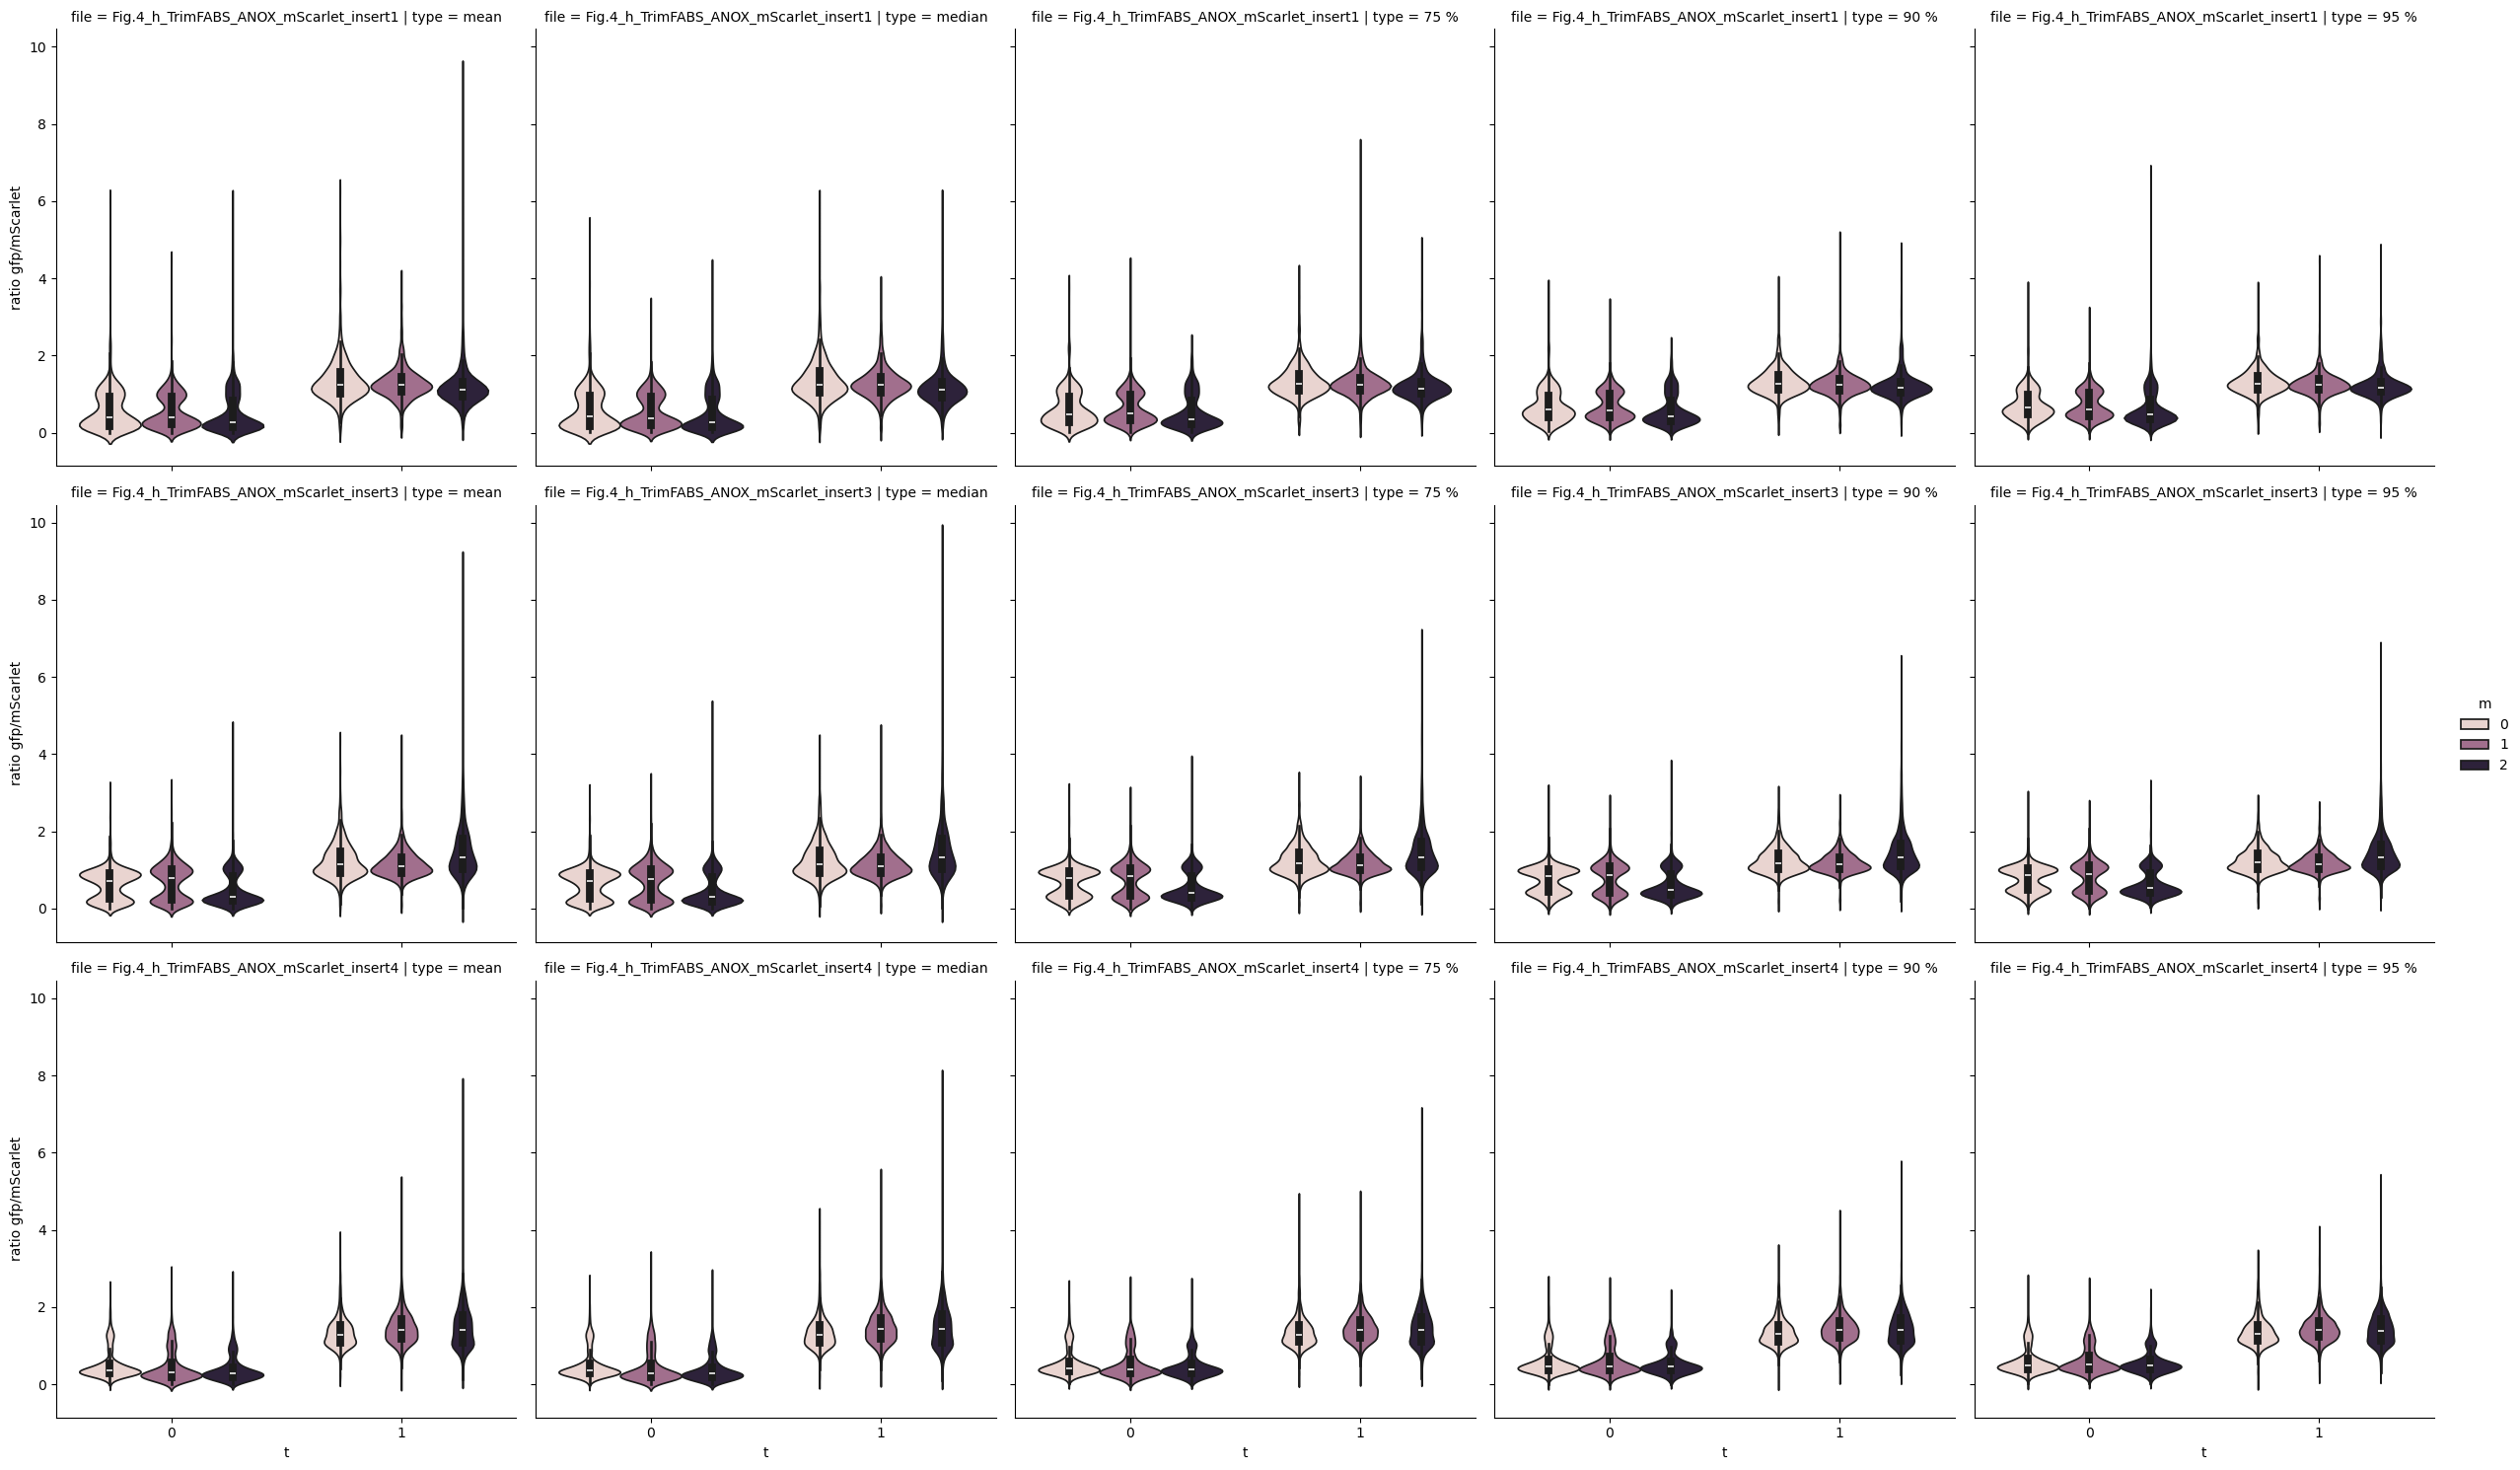

In [148]:
sns.catplot(
    data=df,
    x="t",
    y="ratio gfp/mScarlet",
    hue="m",
    col="type",
    row="file",
    kind="violin",
)

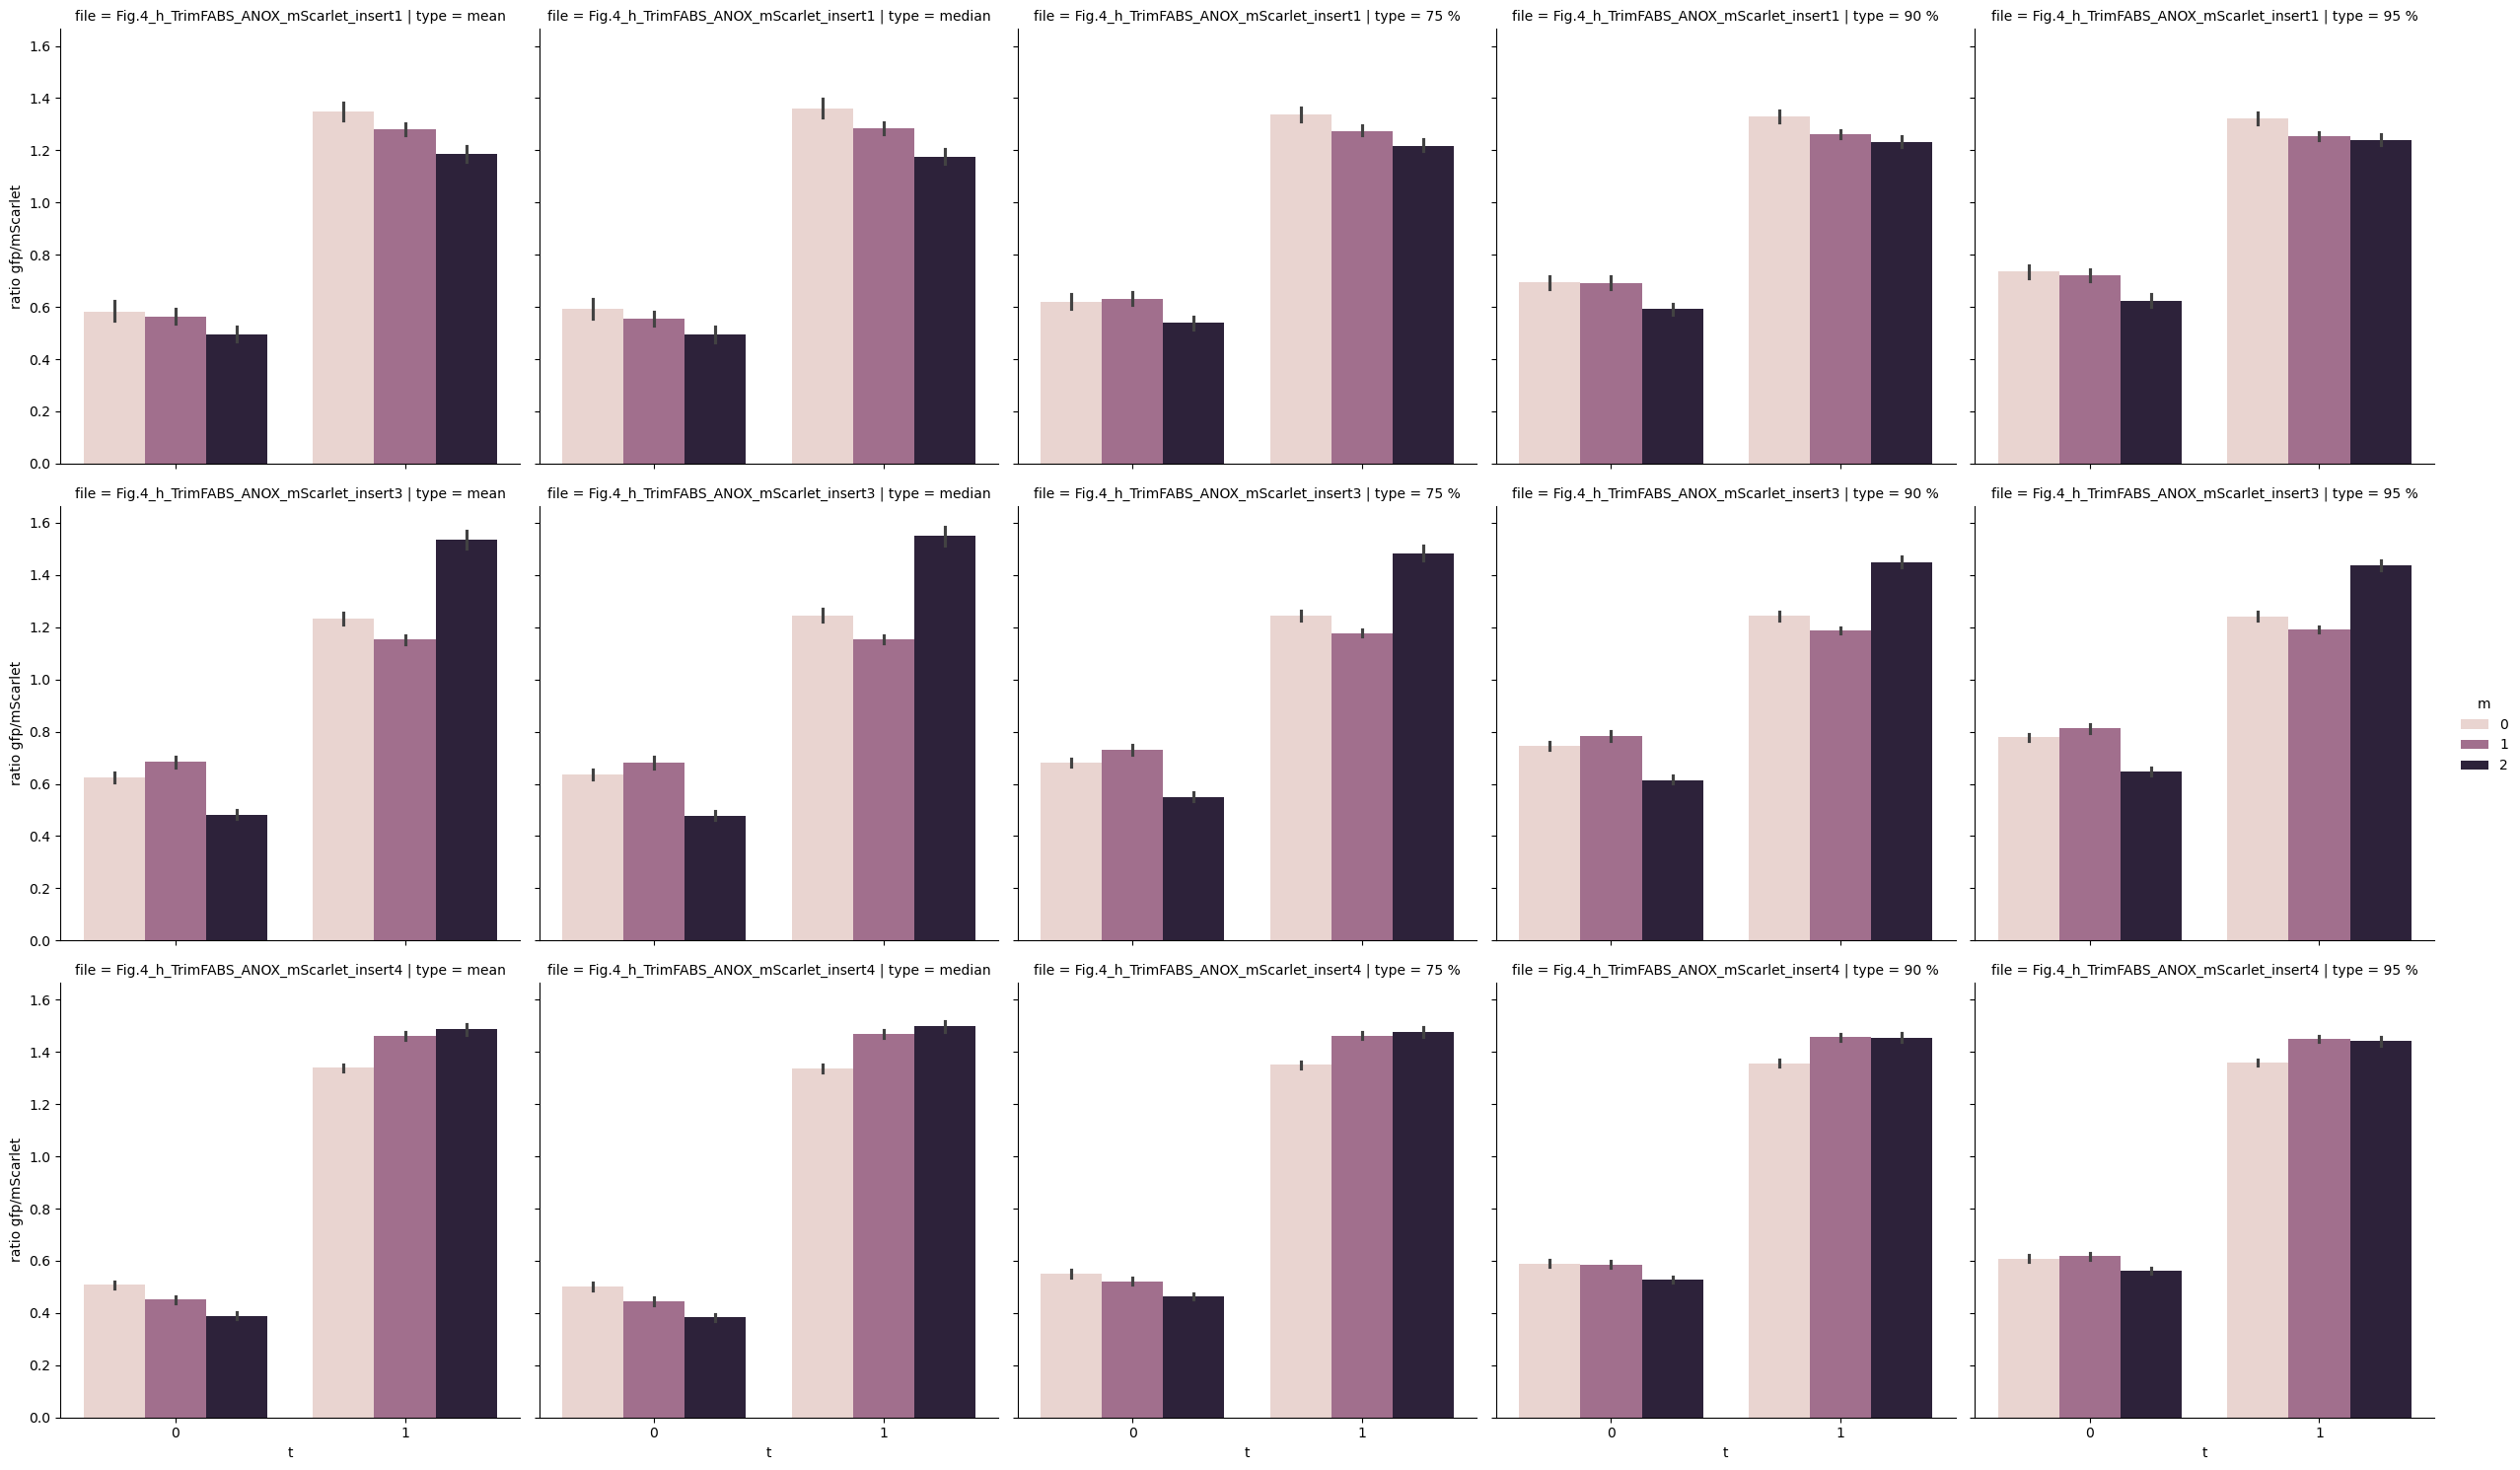

In [149]:
sns.catplot(
    data=df,
    x="t",
    y="ratio gfp/mScarlet",
    hue="m",
    col="type",
    row="file",
    kind="bar",
)

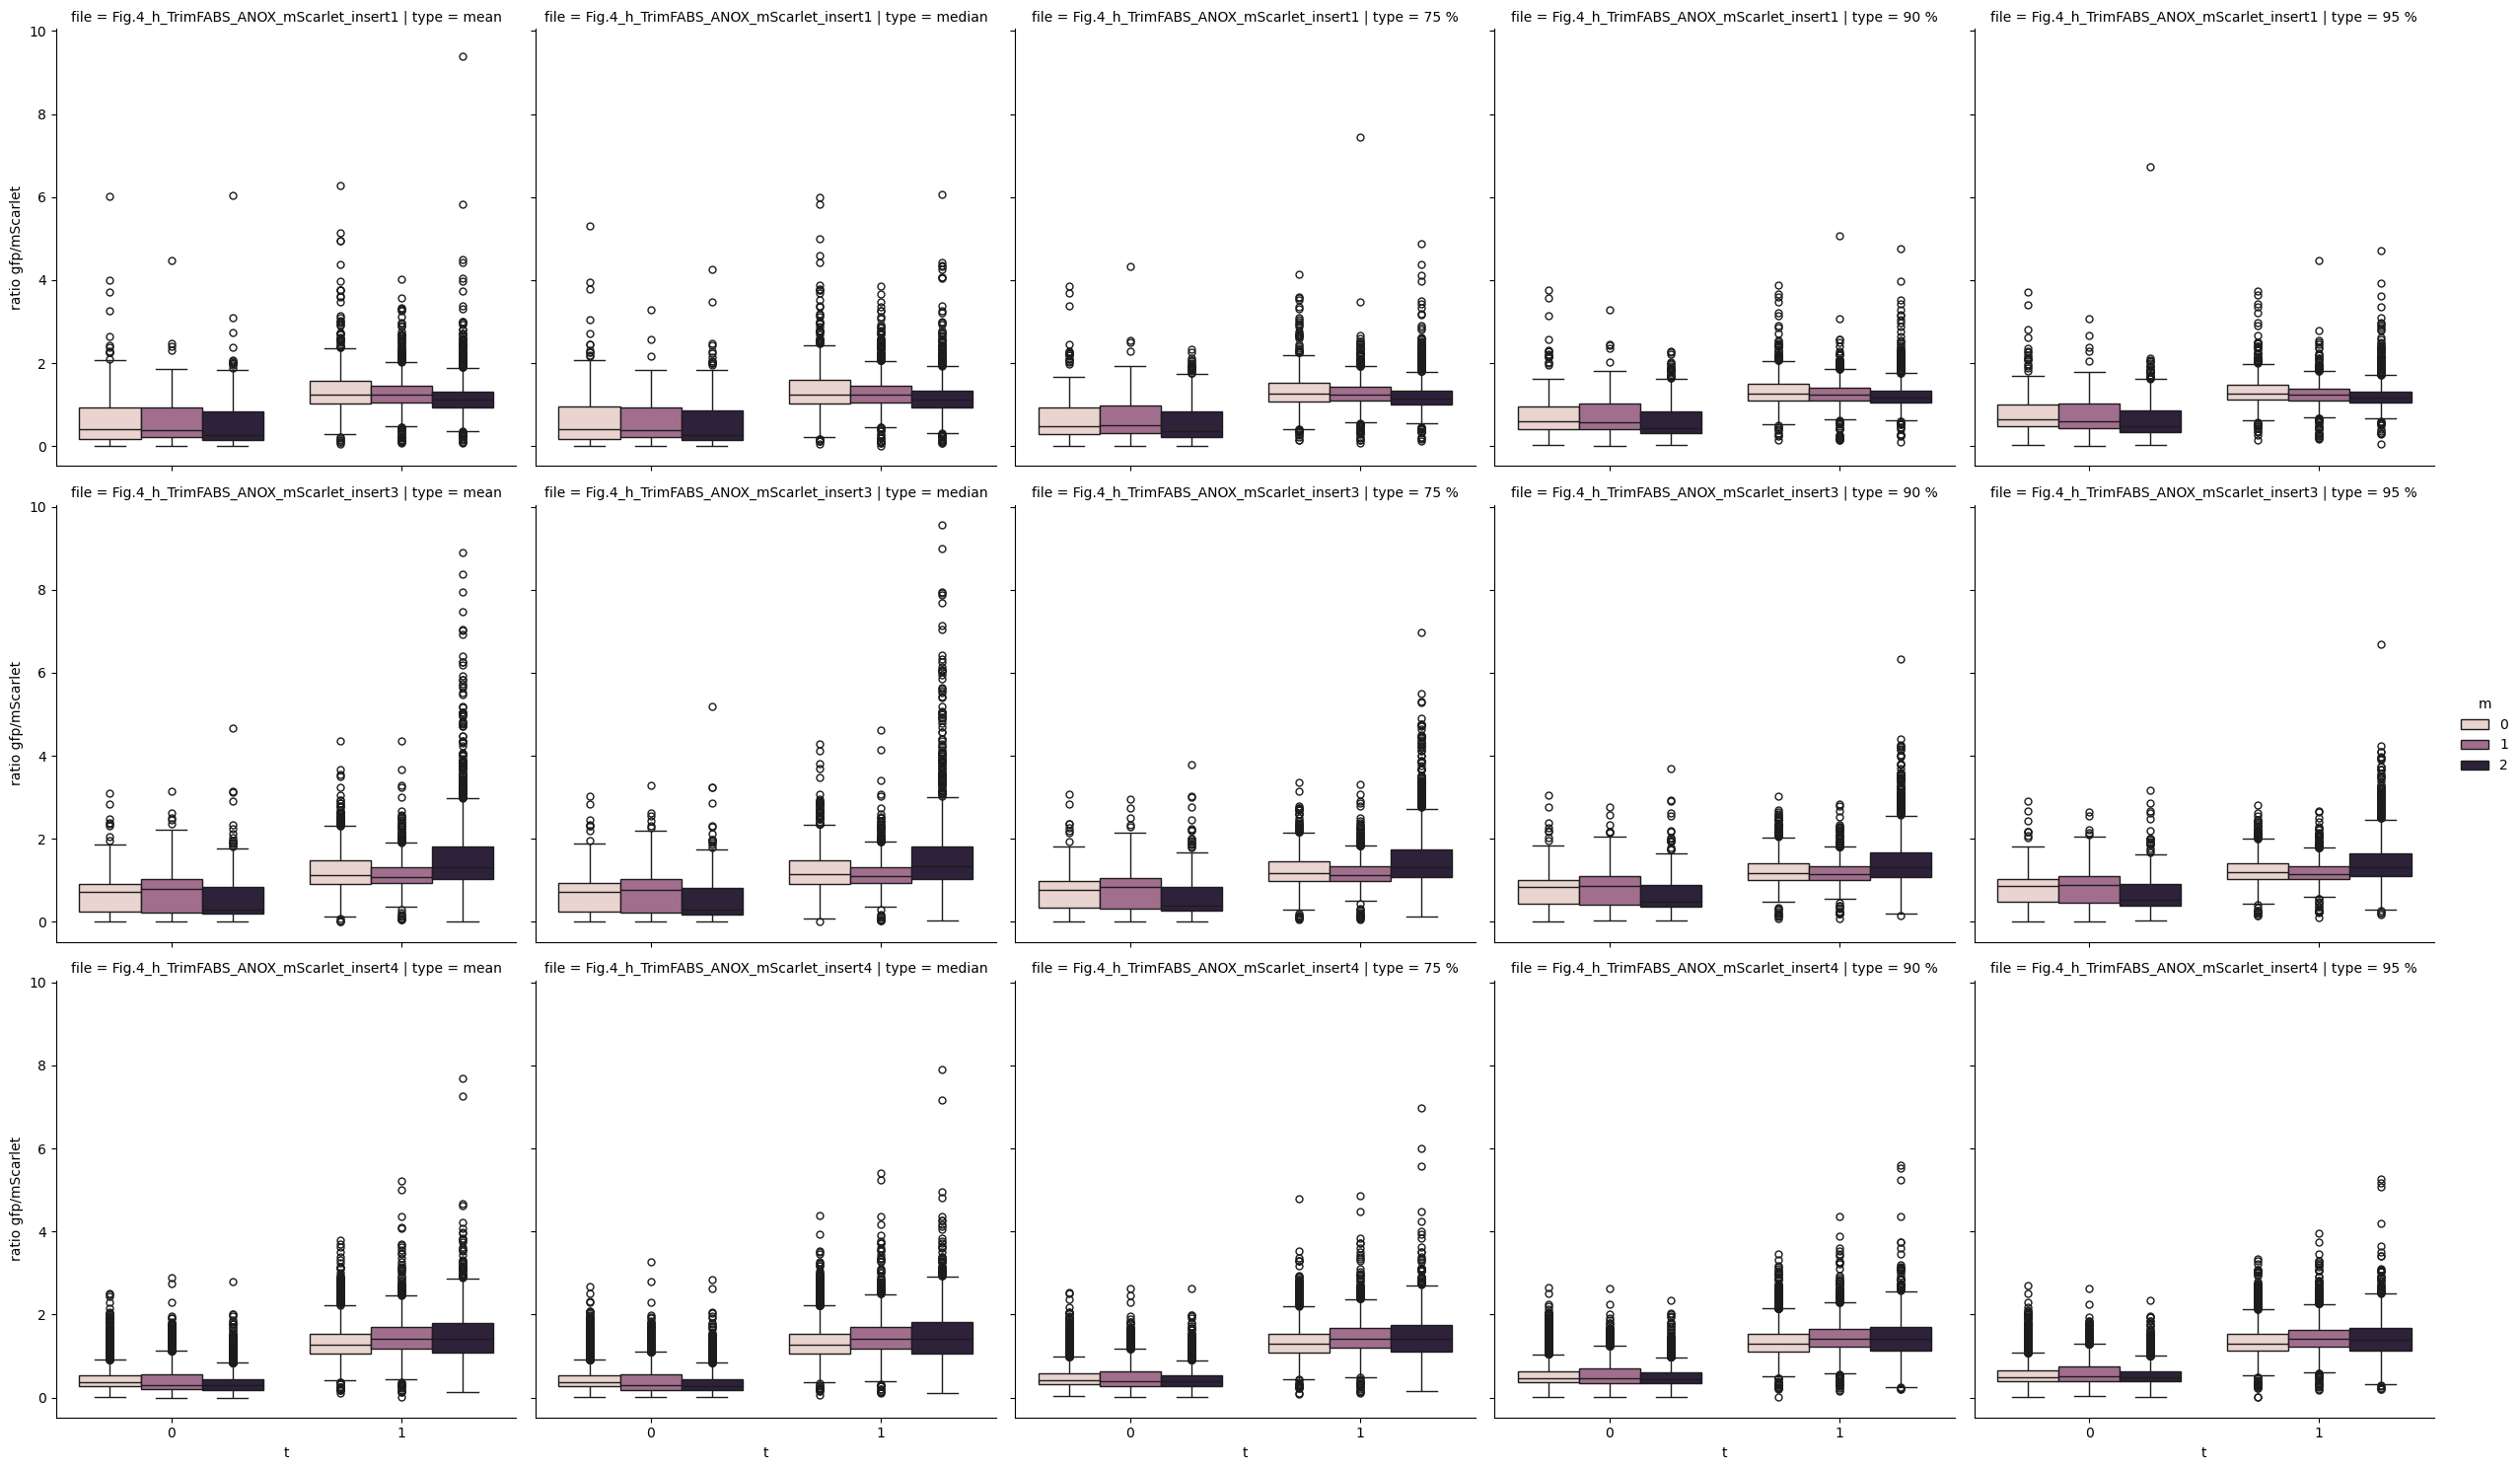

In [150]:
sns.catplot(
    data=df,
    x="t",
    y="ratio gfp/mScarlet",
    hue="m",
    col="type",
    row="file",
    kind="box",
)

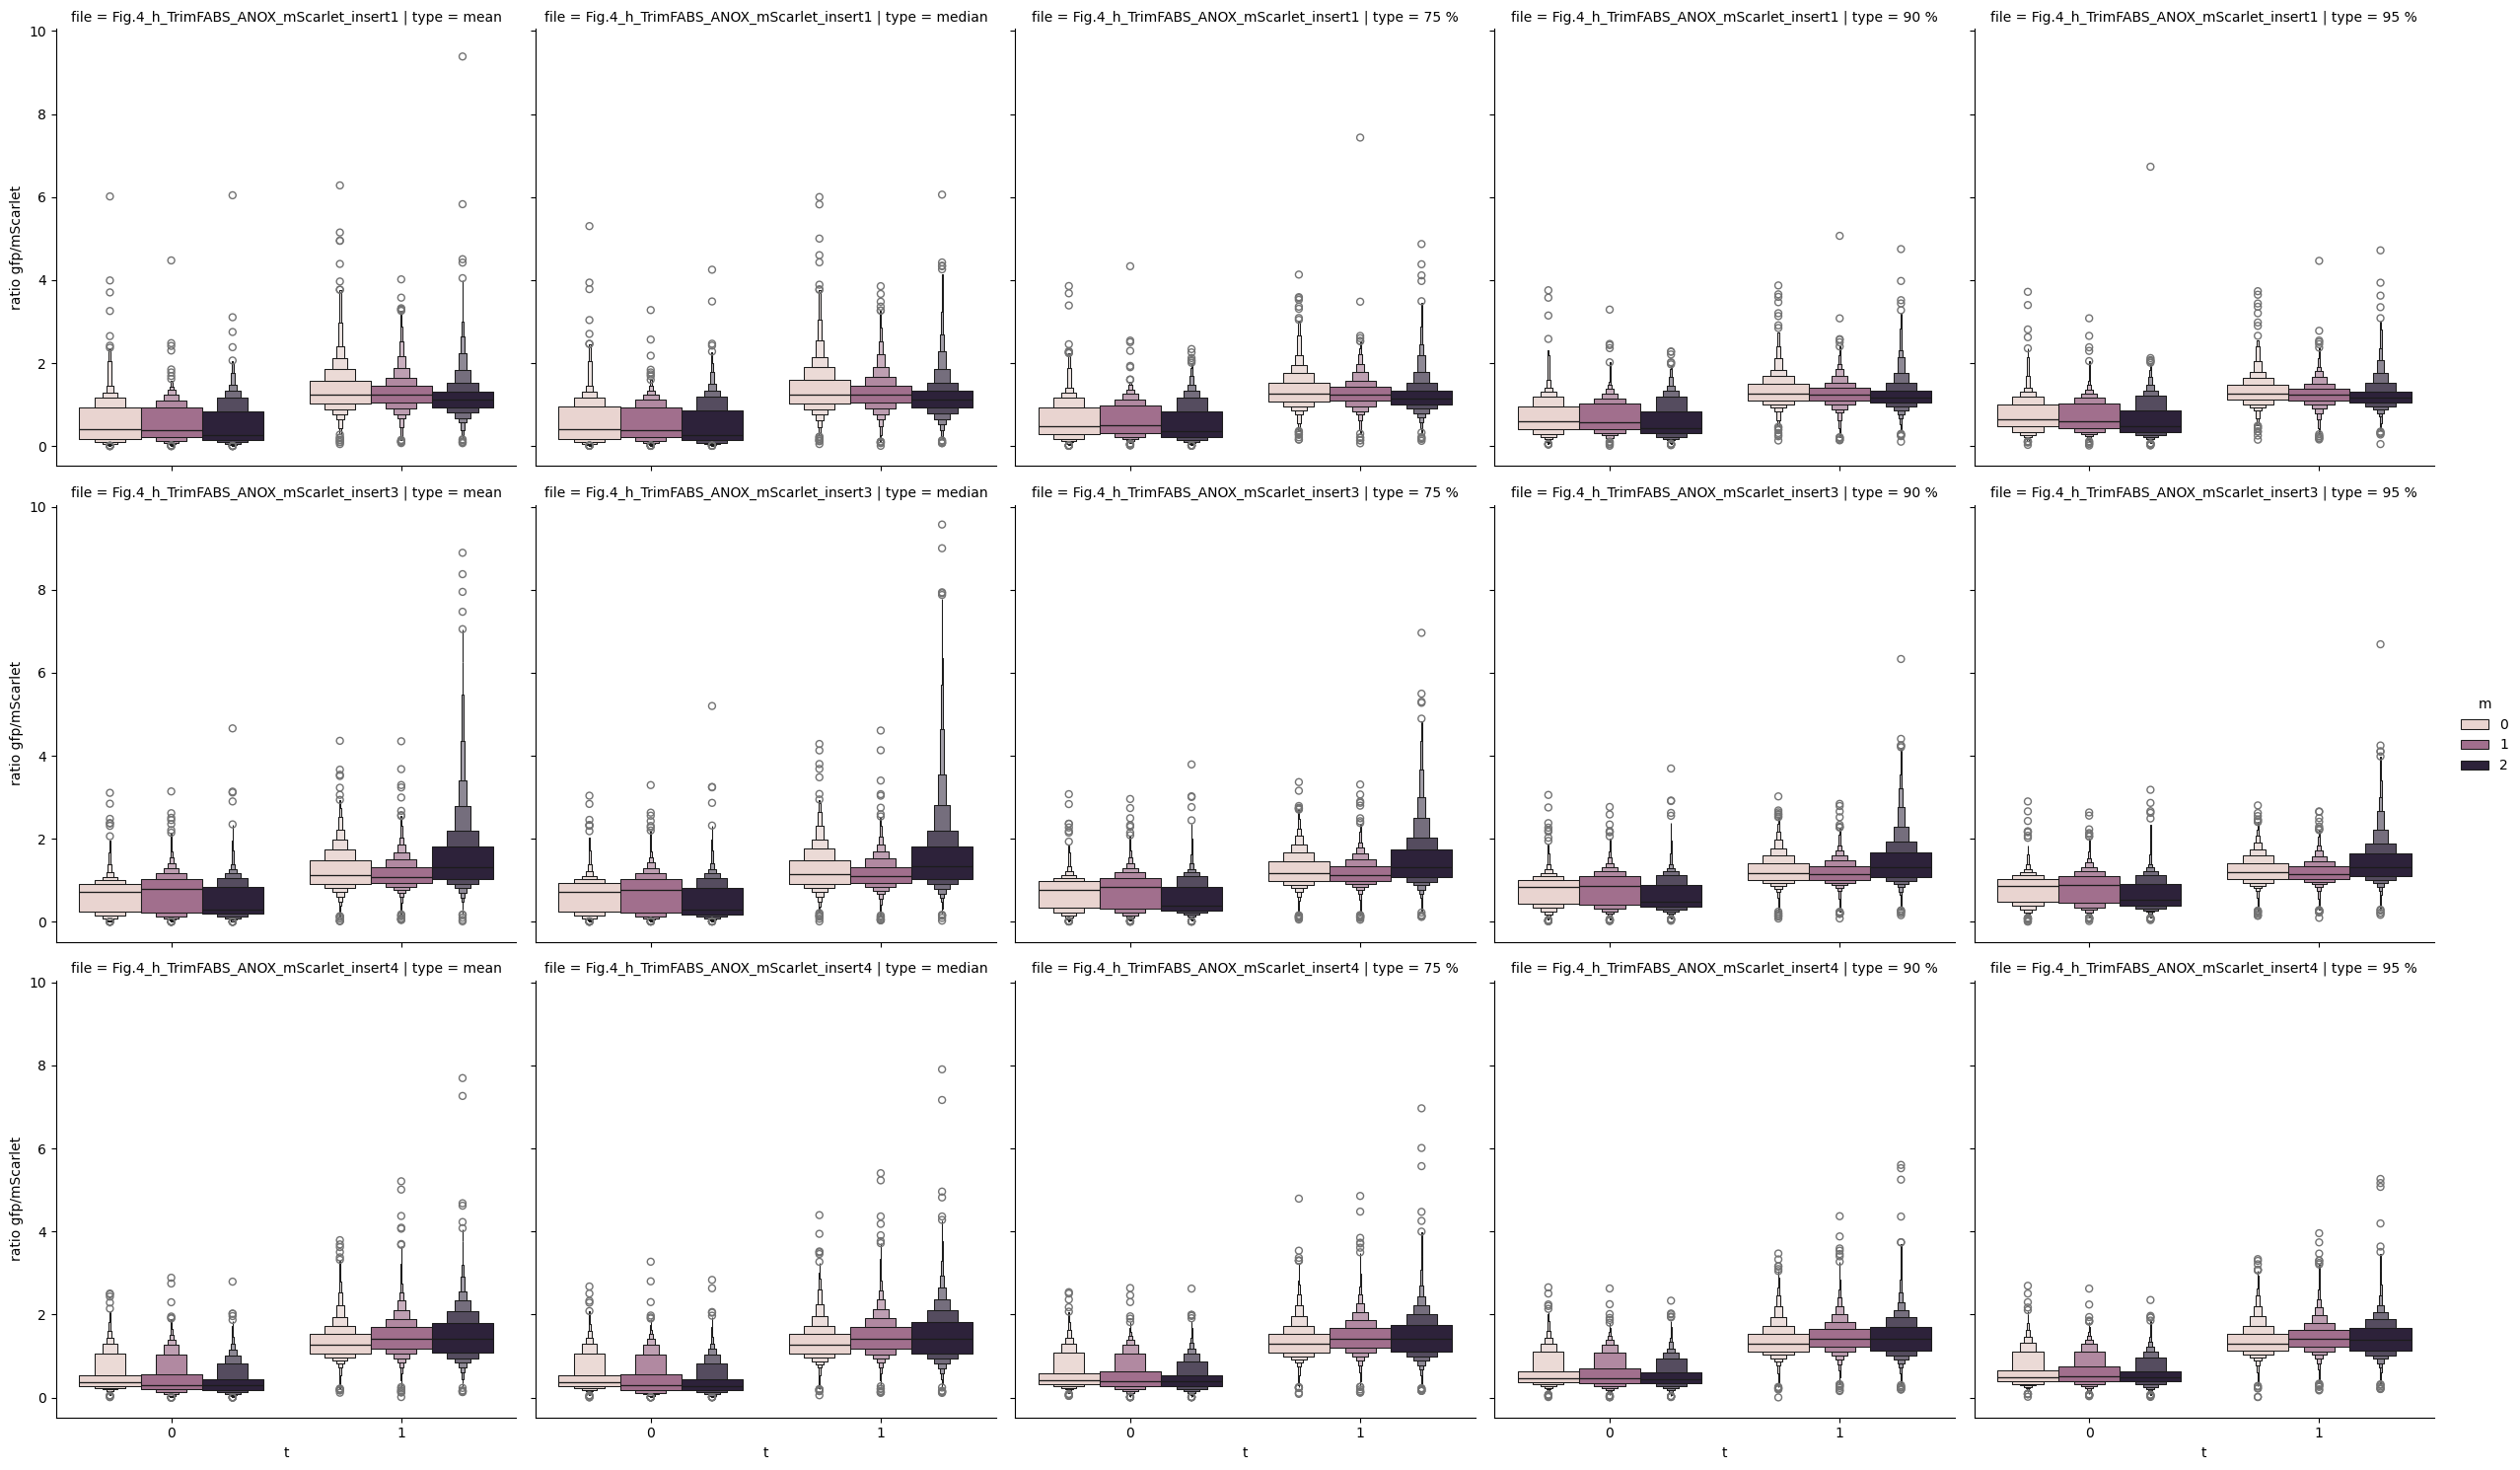

In [151]:
sns.catplot(
    data=df,
    x="t",
    y="ratio gfp/mScarlet",
    hue="m",
    col="type",
    row="file",
    kind="boxen",
)

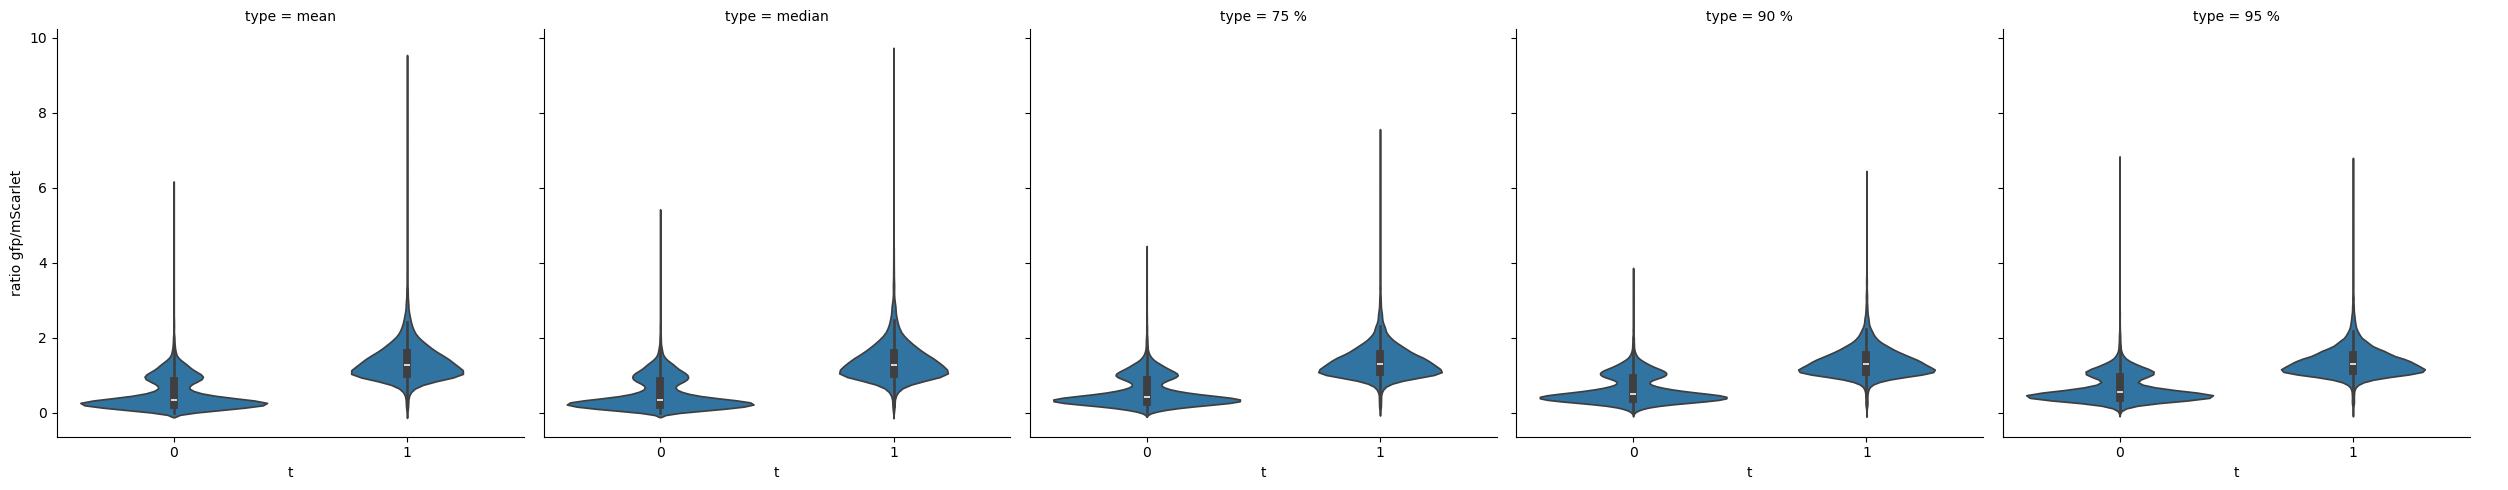

In [152]:
sns.catplot(
    data=df,
    x="t",
    y="ratio gfp/mScarlet",
    col="type",
    kind="violin",
)

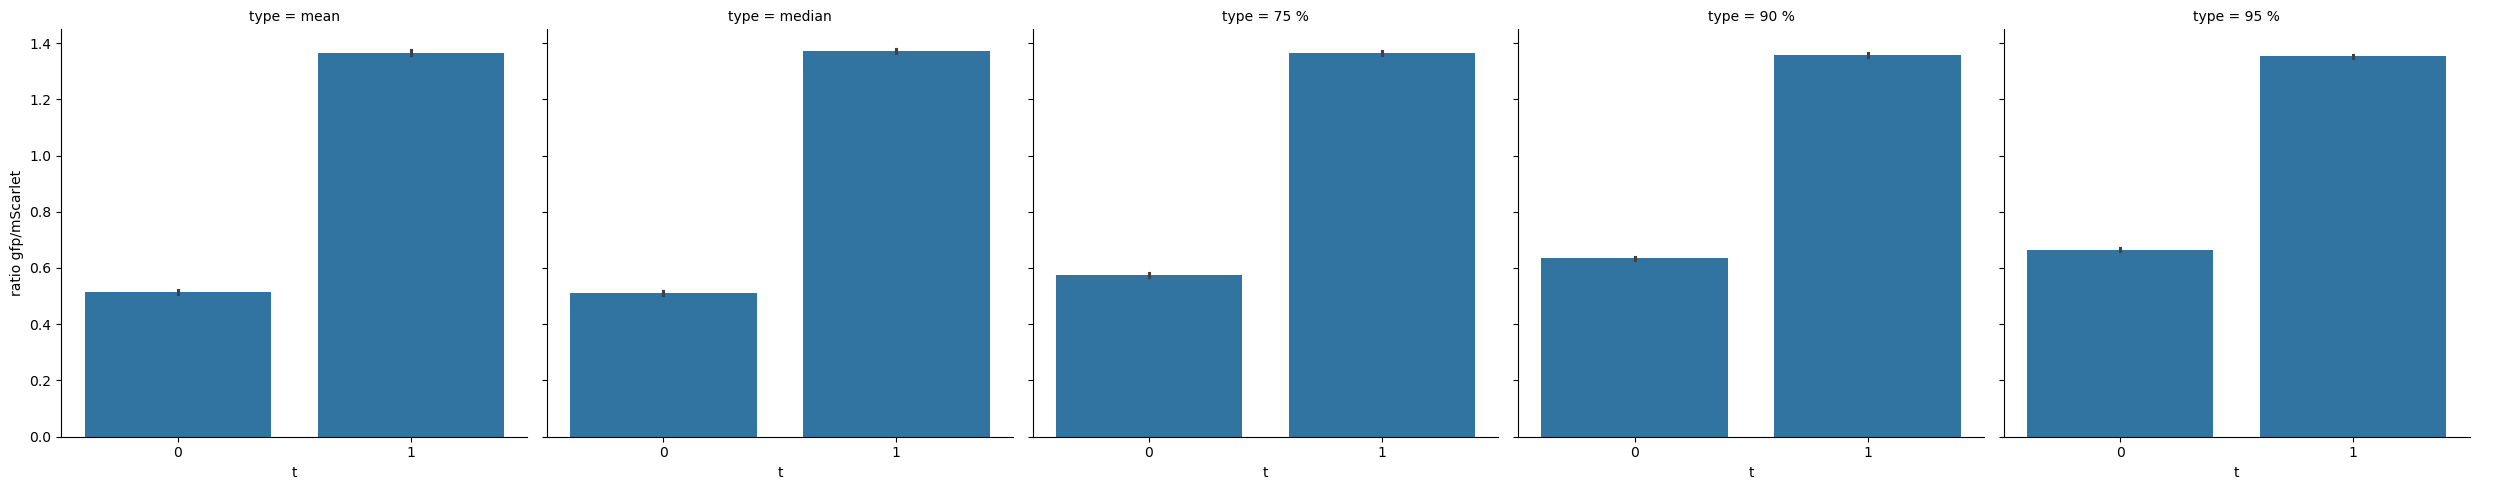

In [154]:
sns.catplot(
    data=df,
    x="t",
    y="ratio gfp/mScarlet",
    col="type",
    kind="bar",
)

In [51]:
t = 1
m = 0
file = "Fig.4_h_TrimFABS_ANOX_mScarlet_insert1"
filename = f"{file}_t{t}_m{m}_mScarlet.tiff"

lbl = imread(os.path.join(root, "nfmp_prob0.6", model, filename))

In [52]:
nd2_file = nd2.ND2File(os.path.join(root, file+".nd2"))
img = nd2_file.to_dask()[t, m, :, 1:].compute().transpose(0, 2, 3, 1)
nd2_file.close()

In [53]:
img.shape

(55, 2304, 2304, 2)

In [54]:
objects = find_objects(lbl)

In [55]:
def calc_ratios(values):
    means = np.concat((
        np.mean(values, axis=0)[np.newaxis, :],
        np.percentile(values, q=[50, 75, 90, 95], axis=0),
    ), axis=0)
    return means[:, 1] / means[:, 0]


values = []
for i, sl in enumerate(objects,1):
    if sl is None: continue
    mask = lbl[sl] == i
    values.append(calc_ratios(img[sl][mask]))
values = np.stack(values, axis=0)

In [50]:
values.mean(axis=0), values.std(axis=0)

(array([1.1023186 , 1.1014014 , 1.09935325, 1.09962175, 1.09893422]),
 array([0.19112884, 0.19293558, 0.19846009, 0.20013348, 0.19924034]))

In [56]:
values.mean(axis=0), values.std(axis=0)

(array([1.31924741, 1.32163299, 1.32285694, 1.32185612, 1.320456  ]),
 array([0.15012739, 0.14861554, 0.15402958, 0.15645776, 0.15950872]))

In [58]:
values

array([[2.61155794, 2.60540541, 2.56521739, 2.6235589 , 2.69683698],
       [1.46027944, 1.51301115, 1.52836879, 1.39287945, 1.38871668],
       [1.07239369, 1.05487805, 1.07142857, 1.07548973, 1.08359693],
       ...,
       [1.28881424, 1.2735426 , 1.32352941, 1.33566978, 1.30665669],
       [1.21370112, 1.22285714, 1.22447183, 1.19389764, 1.1837316 ],
       [1.27312628, 1.28301887, 1.31194296, 1.27973199, 1.27007887]],
      shape=(997, 5))